<a href="https://colab.research.google.com/github/novtryrezki/Terbaru/blob/main/2FFNN_bs_64_ep_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import shutil
import numpy as np
import tensorflow as tf
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split

In [2]:
# Melakukan mount pada Google Drive
drive.mount('/content/drive')

# Menentukan path file ZIP di Google Drive
zip_path = '/content/drive/MyDrive/images.zip'

# Membuat objek zip_ref
zip_ref = zipfile.ZipFile(zip_path, 'r')

# Mengekstrak file ZIP
extract_path ='/content/images'
zip_ref.extractall(extract_path)

# Tutup objek zip_ref setelah selesai
zip_ref.close()

Mounted at /content/drive


In [3]:
# Mendefinisikan path direktori dataset
dataset_dir = os.path.join(extract_path, 'images')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
list_train = sorted(os.listdir(train_dir))
list_test = sorted(os.listdir(test_dir))

print("Daftar Angka pada Dataset Train yaitu : ", list_train)
print("Daftar Angka pada Dataset Test yaitu : ", list_test)

Daftar Angka pada Dataset Train yaitu :  ['angka 0', 'angka 1', 'angka 2', 'angka 3', 'angka 4', 'angka 5', 'angka 6', 'angka 7', 'angka 8', 'angka 9']
Daftar Angka pada Dataset Test yaitu :  ['angka 0', 'angka 1', 'angka 2', 'angka 3', 'angka 4', 'angka 5', 'angka 6', 'angka 7', 'angka 8', 'angka 9']


In [4]:
def count_images(directory):
    return sum(1 for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png', '.gif')))

# Menghitung jumlah gambar di data train
train_image_count = sum(count_images(os.path.join(train_dir, angka)) for angka in list_train)

# Menghitung jumlah gambar di data test
test_image_count = sum(count_images(os.path.join(test_dir, angka)) for angka in list_test)

print(f"Jumlah gambar di Dataset Train: {train_image_count}")
print(f"Jumlah gambar di Dataset Test: {test_image_count}")

Jumlah gambar di Dataset Train: 1763
Jumlah gambar di Dataset Test: 445


# Preprocessing

In [5]:
import cv2

def resize_images(directory, target_resolution):
    for angka in os.listdir(directory):
        angka_dir = os.path.join(directory, angka)
        for file_name in os.listdir(angka_dir):
            file_path = os.path.join(angka_dir, file_name)
            img = cv2.imread(file_path)
            resized_img = cv2.resize(img, (target_resolution[0], target_resolution[1]))
            cv2.imwrite(file_path, resized_img)

target_resolution = (52, 78)
resize_images(train_dir, target_resolution)
resize_images(test_dir, target_resolution)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Membuat generator data dengan augmentasi
image_size = (52, 78)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

for i in range(10):
    batch = train_generator.next()

Found 1763 images belonging to 10 classes.
Found 445 images belonging to 10 classes.


# Membuat Model FFNN

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
import math

img_size = 52*78*1

# Perhitungan jumlah neuron pada lapisan tersembunyi
r = (img_size/10) ** (1/3)

hidden_neurons1 = 10 * r**(2)
hidden_neurons2 = 10 * r**(1)

model2f = Sequential()
model2f.add(Flatten(input_shape=(52, 78, 1)))
model2f.add(Dense(hidden_neurons1, activation='relu'))
model2f.add(Dense(hidden_neurons2, activation='relu'))
model2f.add(Dense(10, activation='softmax'))

model2f.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Mendapatkan bobot dari model
weights = []
for layer in model2f.layers:
    weights.append(layer.get_weights())

print("Bobot dari model:")
for i, layer_weights in enumerate(weights):
    print("Layer", i+1)
    for j, w in enumerate(layer_weights):
        print("  Bobot {}: {}".format(j+1, w.shape))

Bobot dari model:
Layer 1
Layer 2
  Bobot 1: (4056, 547)
  Bobot 2: (547,)
Layer 3
  Bobot 1: (547, 74)
  Bobot 2: (74,)
Layer 4
  Bobot 1: (74, 10)
  Bobot 2: (10,)


In [16]:
# Menampilkan matriks bobot dari model
for i, layer in enumerate(model2f.layers):
    weights = layer.get_weights()
    if weights:
        print("Layer", i+1)
        for j, w in enumerate(weights):
            print("  Bobot {}: \n{}".format(j+1, w))

Layer 2
  Bobot 1: 
[[ 0.02803388  0.02722706  0.00221208 ...  0.03379984  0.03033873
  -0.01050138]
 [-0.00115402 -0.0133857  -0.03225978 ... -0.0257582  -0.02950748
   0.032685  ]
 [ 0.0012253  -0.00741899 -0.02673221 ... -0.01621299  0.00532549
  -0.00490836]
 ...
 [-0.00111381 -0.00807236 -0.02418767 ... -0.02421093 -0.01504765
   0.01357019]
 [-0.01508303 -0.01541888  0.01637306 ... -0.02835989 -0.01000664
   0.01338858]
 [ 0.00200442 -0.03404179  0.01123878 ...  0.03326877 -0.00802461
  -0.01246784]]
  Bobot 2: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [17]:
# Menampilkan matriks bobot dan vektor bias dari setiap layer
for i, layer in enumerate(model2f.layers):
    weights = layer.get_weights()
    if weights:
        print("Layer", i+1)
        for j, w in enumerate(weights):
            if j == 0:
                print("  Bobot:")
            else:
                print("  Bias:")
            print("    Ukuran:", w.shape)
            print("    Nilai:")
            print(w)

Layer 2
  Bobot:
    Ukuran: (4056, 547)
    Nilai:
[[ 0.02803388  0.02722706  0.00221208 ...  0.03379984  0.03033873
  -0.01050138]
 [-0.00115402 -0.0133857  -0.03225978 ... -0.0257582  -0.02950748
   0.032685  ]
 [ 0.0012253  -0.00741899 -0.02673221 ... -0.01621299  0.00532549
  -0.00490836]
 ...
 [-0.00111381 -0.00807236 -0.02418767 ... -0.02421093 -0.01504765
   0.01357019]
 [-0.01508303 -0.01541888  0.01637306 ... -0.02835989 -0.01000664
   0.01338858]
 [ 0.00200442 -0.03404179  0.01123878 ...  0.03326877 -0.00802461
  -0.01246784]]
  Bias:
    Ukuran: (547,)
    Nilai:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [18]:
model2f.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 4056)              0         
                                                                 
 dense_3 (Dense)             (None, 547)               2219179   
                                                                 
 dense_4 (Dense)             (None, 74)                40552     
                                                                 
 dense_5 (Dense)             (None, 10)                750       
                                                                 
Total params: 2260481 (8.62 MB)
Trainable params: 2260481 (8.62 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
history = model2f.fit(train_generator, epochs=20, verbose = 1)

Epoch 1/20
28/28 [==============================] - 3s 70ms/step - loss: 2.0667 - accuracy: 0.2830
Epoch 2/20
28/28 [==============================] - 2s 69ms/step - loss: 1.9653 - accuracy: 0.3437
Epoch 3/20
28/28 [==============================] - 2s 69ms/step - loss: 1.9324 - accuracy: 0.3545
Epoch 4/20
28/28 [==============================] - 2s 68ms/step - loss: 1.8987 - accuracy: 0.3755
Epoch 5/20
28/28 [==============================] - 2s 75ms/step - loss: 1.9190 - accuracy: 0.3562
Epoch 6/20
28/28 [==============================] - 3s 103ms/step - loss: 1.8666 - accuracy: 0.3789
Epoch 7/20
28/28 [==============================] - 2s 68ms/step - loss: 1.8225 - accuracy: 0.3976
Epoch 8/20
28/28 [==============================] - 2s 68ms/step - loss: 1.8355 - accuracy: 0.3965
Epoch 9/20
28/28 [==============================] - 2s 68ms/step - loss: 1.7726 - accuracy: 0.4152
Epoch 10/20
28/28 [==============================] - 2s 68ms/step - loss: 1.7869 - accuracy: 0.4044
Epoch 11

#Matriks Konfusi

7/7 [==============================] - 0s 31ms/step


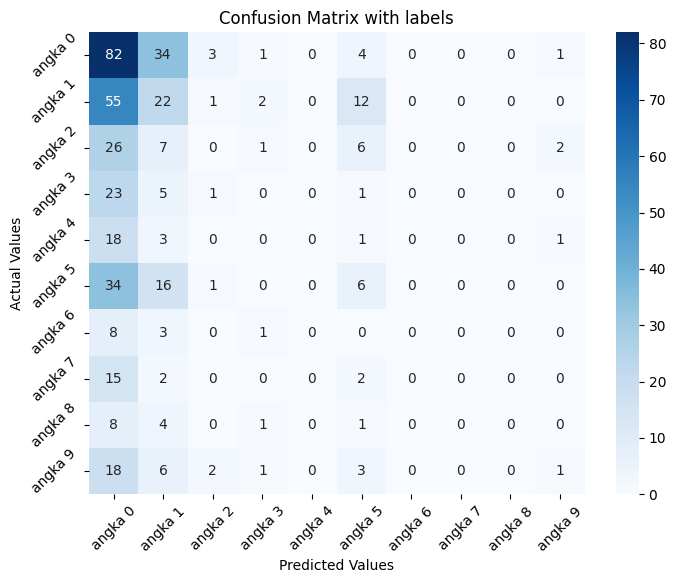

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Fungsi untuk mendapatkan prediksi model dan label sebenarnya
def get_predictions_and_labels(model, data_generator):
    predictions = model.predict(data_generator)
    true_classes = data_generator.classes
    return predictions, true_classes

# Mendapatkan prediksi dan label sebenarnya untuk data uji
y_pred_prob, y_true = get_predictions_and_labels(model2f, test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Membuat matriks konfusi
cf_matrix = confusion_matrix(y_true, y_pred)

# Membuat visualisasi matriks konfusi
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)

# Menetapkan label dan judul
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

class_labels = list(test_generator.class_indices.keys())

# Menetapkan label pada sumbu x dan y sesuai dengan jenis kelas
ax.xaxis.set_ticklabels(class_labels, rotation=45)
ax.yaxis.set_ticklabels(class_labels, rotation=45)

# Menampilkan visualisasi Matriks Konfusi
plt.show()

In [31]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.24943820224719102
